What are my ingredients?

## Latent Mfc vs Mcf function

In [ ]:
def latent_mfc_mcf(model):
    """
    Generates the latent $M^{FC}$ and $M^{CF}$ in the specified ICMR instance.
    For exploring and demonstrating model equivalence, we can calculate for any state of ICMR's dual-store memory 
    array $M$ a corresponding $M^{FC}$ (or $M^{CF}$) by computing for each orthogonal $f_i$ (or $c_i$) the model's 
    corresponding echo representation. 
    """

    encoding_states(model)
    
    # start by finding latent mfc: the contextual representation cued when each orthogonal $f_i$ is cued
    latent_mfc = np.zeros((model.item_count, model.item_count+1))
    cue = np.zeros(model.item_count*2 + 2)
    for i in range(model.item_count):
        cue *= 0
        cue[i+1] = 1
        latent_mfc[i] = model.echo(cue)[model.item_count + 1:]

    # now the latent mcf
    latent_mcf = np.zeros((model.item_count+1, model.item_count))
    for i in range(model.item_count+1):
        cue *= 0
        cue[model.item_count+1+i] = 1
        latent_mcf[i] = model.echo(cue)[1:model.item_count + 1] # start at 1 due to dummy column in F

    # plotting
    return latent_mfc, latent_mcf

# %% [markdown]
# Now we wield our new functions to compare CMR and ICMR's memory representations.

# %%

if True:
    # ICMR
    model = InstanceCMR(**parameters)
    latent_mfc, latent_mcf = latent_mfc_mcf(model)
    print(model.__class__.__name__)
    plot_states(model.memory, 'ICMR Memory')
    plot_states(latent_mfc, 'ICMR Latent Mfc')
    plot_states(latent_mcf, 'ICMR Latent Mcf')

    # CMR
    model = CMR(**parameters)
    encoding_states(model)
    print(model.__class__.__name__)
    plot_states(model.mfc, 'CMR Mfc')
    plot_states(model.mcf, 'CMR Mcf')

## Subject-Level Plotting Code

The problem with a violin plot actually is that points aren't matched to one another - I can't clearly tell whether the values differ substantially between models for a given subject. Instead, I'll use a line plot that maybe plots a marginal distribution on the edges. If the corresponding line has a slope of 1, then even when you consider subject by subject, the models obtain similar fits.

When I'm comparing fits across list types, I can draw inspiration from the more extended documentation [here](https://seaborn.pydata.org/generated/seaborn.jointplot.html). 

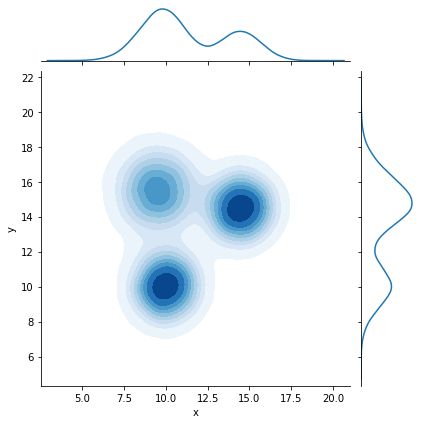

In [1]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Dataset:
df=pd.DataFrame({'x': np.random.normal(10, 1.2, 20000), 'y': np.random.normal(10, 1.2, 20000), 'group': np.repeat('A',20000) })
tmp1=pd.DataFrame({'x': np.random.normal(14.5, 1.2, 20000), 'y': np.random.normal(14.5, 1.2, 20000), 'group': np.repeat('B',20000) })
tmp2=pd.DataFrame({'x': np.random.normal(9.5, 1.5, 20000), 'y': np.random.normal(15.5, 1.5, 20000), 'group': np.repeat('C',20000) })
df=df.append(tmp1).append(tmp2)

# 2D density + marginal distribution:
sns.jointplot(x=df.x, y=df.y, cmap="Blues", shade=True, kind='kde')
plt.show()

## AIC Code
Okay, so supppose I have 21239 in one dataset... CMR
21073 in ICMR

Sample size of 9380.

In [19]:
import numpy as np

def aic(ll_A, ll_B, parameter_count, sample_size):
    """
    This value is calculated for every candidate model and the best model is 
    the candidate model with the smallest AIC. We convert these into AIC 
    weights to estimate the probability that each model generated the data, 
    under the assumption that one of them did.
    """
    aic_A = 2 * ll_A + (2 * parameter_count) + ((2 * parameter_count)*(parameter_count+1))/(sample_size - parameter_count - 1)
    aic_B = 2 * ll_B + (2 * parameter_count) + ((2 * parameter_count)*(parameter_count+1))/(sample_size - parameter_count - 1)
    
    best = min(aic_A, aic_B)
    termA = np.exp(-.5 * (aic_A - best))
    termB = np.exp(-.5 * (aic_B - best))
    
    return best, termA/(termA + termB), termB/(termA + termB)

In [20]:
aic(21239, 21073, 13, 9380)

(42172.038863976086, 8.074506789675094e-73, 1.0)

I'm surprised by how sensitive these computations are; the differences I previously noted as small between CMR and InstanceCMR are regarded as quite large by the AIC-based tests I've been exploring. They extend to the two-list case, too!

## Secondary Baseline Dataset

Sean discourages focusing on the Murdoch dataset because of that odd bump in recall likelihoods for pre-terminally presented items. 

He suggested I try any different dataset from the 2009 paper or: Pierce2016, experiment 3. (exp 1 is good too?) of 2016 paper. Not the Sederberg one - had some quirks. Though could show model handles distraction okay.

I can't get into the memory server for some reason. An alternative strategy might be to look for a dataset in my options that's shared online somewhere.

I'll use the Okada dataset since it has the same size as the Murdoch 1962 dataset and is easy to process. The point is to show that my model comparisons extend to an additional dataset without the bump in PFRs that I showed off to Polyn. 

What does the next phase of my research look like then?

1. Prepare and visualize this new dataset to support the same analyses as I performed w/ the murdock dataset.
2. Run the pipeline across all model versions
2. Extend the pipeline to visualize the distribution of AIC scores across subjects depending on the dataset.

What about the other model comparison issues?

I want to present an analysis of latent Mfc/Mcf to show relative equivalence. Can I concretize that vision a bit better?

A section of my paper outlines a scheme for comparing model states (M, Mfc, Mcf, context) across encoding and retrieval. Figures include a plot of M over encoding. Then Mcf/Mfc vs CMR's. And correspondingly a figure visualizing changes in context/outcome probabilities over the course of retrieval. 

I already have all this code though they made need revision. But I may need to run them all over again.

## Phase Two
Then there's the repetitions analyses.

I similarly want to compute fits both across all subjects/conditions, and within condition/subject. 

That is, I'll fit the model...
1. Across conditions/subjects
2. Between condition
3. Between subject
4. Between condition/subject

Are all these conditions interesting? 

I will certainly be interested in overall fits. Dividing between conditions helps figure out if any dissociation in performance is because of the repetitions or not. Dividing between subjects helps clarify whether intersubject variance is a factor. Dividing between conditions _and_ subjects is mostly about exploring if there's any intersubject variance in the apparent dissociation. All interesting questions, sure. Between subject, though? Perhaps not so much.

Then we need corresponding model analyses. That recall probability by repetition count plot is one step, sure; and using fitted values to underscore these differences matters too.

When I'm fitting between conditions, I get to pose a conflict for the models. How much should item repetition impact recall probability vs how deterministically should recall proceed? The result of my fitting between and across conditions helps clarify how this conflict is negotiated.

I am also supposed to connect this to Lohnas et al's analysis of spacing effects between conditions.

## Phase Three
While one historical contest between prototype-based and instance-based models focused on control over how deterministically recall is carried out (resolved by inclusion of a similar parameter in CMR), the other focuses on selection of _subordinate_ item contexts given a compound cue containing both the item and some context-disambiguating information. CMR sidesteps this issue too as a prototype model by storing and probing item-to-context and context-to-item associations separately. As there's no compound-cued search for particular subsets of contextual associations corresponding to an item, nothing analogous to Jamieson et al's analysis of how prototype- and instance-based semantic memory models represent homonymous and polysemous words seems to emerge for comparison of prototype-based and instance-based CMR.

However, a modification of InstanceCMR that applies compound cue-ing similarly to how Morton and Polyn's combination of item and contextual features to model semantic memory could enable the relevant dissociation?

Maybe, but perhaps not clearly. 